In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import curdoc, output_notebook
from bokeh.models import BoxZoomTool, ResetTool, PanTool, WheelZoomTool, HoverTool
from bokeh.transform import factor_cmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from tqdm import tqdm
import warnings

from statsbombpy import sb

In [3]:
data = pd.read_csv("./data.csv")

In [4]:
data.shape

(9691, 61)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9691 entries, 0 to 9690
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   period                              9691 non-null   int64  
 1   minute                              9691 non-null   int64  
 2   possession                          9691 non-null   int64  
 3   location_x                          9691 non-null   float64
 4   location_y                          9691 non-null   float64
 5   duration                            9691 non-null   float64
 6   first_time                          9691 non-null   bool   
 7   open_goal                           9691 non-null   bool   
 8   one_on_one                          9691 non-null   bool   
 9   statsbomb_xg                        9691 non-null   float64
 10  end_location_x                      9691 non-null   float64
 11  end_location_y                      9691 no

In [6]:
data.nunique()

period                    5
minute                  134
possession              278
location_x              436
location_y              539
                       ... 
body_part_Right Foot      2
type_Corner               2
type_Free Kick            2
type_Open Play            2
type_Penalty              2
Length: 61, dtype: int64

<AxesSubplot:>

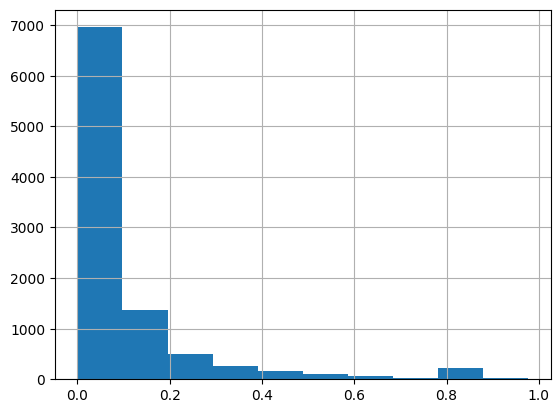

In [7]:
data["statsbomb_xg"].hist()

In [8]:
def plot_coordinates(x, y, title='Scatter Plot of X and Y Coordinates', color="cyan", color_map=None, size_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)

    use_color = color_map if color_map is not None else color
    use_size = size_map if size_map is not None else 5
    p.scatter(x, y, size=use_size, color=use_color, alpha=0.5, legend_label='Data')

    p.x_range.start = 0
    p.y_range.start = 0
    p.x_range.end = 120
    p.y_range.end = 80

    p.xaxis.axis_label = 'X Coordinate'
    p.yaxis.axis_label = 'Y Coordinate'
    p.grid.visible = True
    p.segment(x0=102, y0=18, x1=102, y1=62, color="white", line_width=0.5)
    p.segment(x0=102, y0=18, x1=120, y1=18, color="white", line_width=0.5)
    p.segment(x0=102, y0=62, x1=120, y1=62, color="white", line_width=0.5)

    hover = HoverTool(tooltips=[('X', '@x'), ('Y', '@y')])
    p.add_tools(hover)
    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [9]:
def plot_scatter(x, y, title='Scatter Plot of X and Y Coordinates', x_label='X', y_label='Y', color="cyan", color_map=None, size_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)

    use_color = color_map if color_map is not None else color
    use_size = size_map if size_map is not None else 8
    p.scatter(x, y, size=use_size, color=use_color, alpha=0.5, legend_label='Data')

    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.grid.visible = True

    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    trendline = slope * x + intercept
    p.line(x, trendline, line_color='blue', line_width=1, legend_label='Trendline')

    hover = HoverTool(tooltips=[('X', '@x'), ('Y', '@y')])
    p.add_tools(hover)
    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [10]:
def plot_histogram(data, bins=10, title='Frequency of Data', x_label='Value', y_label='Frequency', is_goal=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)
    hist, edges = np.histogram(data, bins=bins)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='grey', line_color='white', alpha=0.4)

    hist, edges = np.histogram(data[is_goal == True], bins=bins)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='cyan', line_color='white', alpha=0.4)

    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.grid.visible = True

    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [11]:
def plot_pass_map(df, title='Pass Map', color_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)
    p.scatter(x=df["location_x"], y=df["location_y"], size=1, color='grey', legend_label='Start')
    p.scatter(x=df["end_location_x"], y=df["end_location_y"], size=1, color='red', legend_label='End')
    for _, row in df.iterrows():
        p.line([row['location_x'], row['end_location_x']], [row['location_y'], row['end_location_y']], line_color='cyan')

    p.x_range.start = 0
    p.y_range.start = 0
    p.x_range.end = 120
    p.y_range.end = 80

    p.xaxis.axis_label = 'X Coordinate'
    p.yaxis.axis_label = 'Y Coordinate'
    p.grid.visible = True

    hover = HoverTool(tooltips=[('X', '@x'), ('Y', '@y')])
    p.add_tools(hover)
    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

    # Show the plot
    show(p)

In [12]:
def plot_bar_chart(data_df, column):
    value_counts = data_df[column].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Frequency of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

In [13]:
def plot_area_chart(sequence):
    plt.fill_between(range(len(sequence)), sequence, color="skyblue", alpha=0.4)
    plt.plot(sequence, color="Slateblue", alpha=0.6, linewidth=2)
    plt.xlabel("Threshold (times 10)")
    plt.ylabel("F1 score")
    plt.title("ROC")
    plt.show()

In [14]:
data = data[data["type_Penalty"] == False]

In [15]:
plot_coordinates(data['location_x'], data['location_y'], "Shot Locations", color_map=data["is_goal"].map({True: 'cyan', False: 'grey'}), size_map=data['statsbomb_xg'].apply(lambda x: x*15))

Loading BokehJS ...

In [16]:
plot_histogram(data["location_x"], bins=120, title="Distribution of x-coordinates", x_label="x-coordinate", is_goal=data["is_goal"])

Loading BokehJS ...

In [17]:
plot_histogram(data["location_y"], bins=120, title="Distribution of y-coordinates", x_label="y-coordinate", is_goal=data["is_goal"])

Loading BokehJS ...

In [18]:
shots_per_minute = data['minute'].value_counts().sort_index()[:90]
plot_scatter(data['minute'].unique()[:90], shots_per_minute, "Shots per Minute", x_label="Minute", y_label="Number of Shots", color="grey")

Loading BokehJS ...

In [19]:
shots_per_minute = data['possession'].value_counts().sort_index()[:90]
plot_scatter(data['possession'].unique()[:90], shots_per_minute, "Shots per Minute", x_label="Minute", y_label="Number of Shots", color="grey")

Loading BokehJS ...

In [20]:
goals_per_minute = data[data["is_goal"] == True]['minute'].value_counts().sort_index()[:90]
plot_scatter(data['minute'].unique()[:90], goals_per_minute, "Goals per Minute", x_label="Minute", y_label="Number of Goals", color="cyan")

Loading BokehJS ...

In [21]:
plot_histogram(data["minute"], bins=130, title="Distribution of shot times", x_label="Minute", is_goal=data["is_goal"])

Loading BokehJS ...

In [22]:
restricted_data = data[data["minute"] < 100]
restricted_data = restricted_data[restricted_data["location_x"] > 70]
plot_scatter(restricted_data['minute'], restricted_data["location_x"], "x-coordinate of Shots by Minute", x_label="Minute", y_label="x-coordinate", color_map=restricted_data["is_goal"].map({True: 'cyan', False: 'grey'}))

Loading BokehJS ...

In [23]:
restricted_data = data[data["minute"] < 100]
mean_location_y = restricted_data['location_y'].mean()
deviation_from_mean = abs(restricted_data["location_y"] - mean_location_y)
plot_scatter(restricted_data['minute'], deviation_from_mean, "y-coordinate of Shots by Minute", x_label="Minute", y_label="y-coordinate", color_map=restricted_data["is_goal"].map({True: 'cyan', False: 'grey'}))

Loading BokehJS ...

In [24]:
data.columns

Index(['period', 'minute', 'possession', 'location_x', 'location_y',
       'duration', 'first_time', 'open_goal', 'one_on_one', 'statsbomb_xg',
       'end_location_x', 'end_location_y', 'is_goal',
       'play_pattern_From Corner', 'play_pattern_From Counter',
       'play_pattern_From Free Kick', 'play_pattern_From Goal Kick',
       'play_pattern_From Keeper', 'play_pattern_From Kick Off',
       'play_pattern_From Throw In', 'play_pattern_Other',
       'play_pattern_Regular Play', 'position_Center Attacking Midfield',
       'position_Center Back', 'position_Center Defensive Midfield',
       'position_Center Forward', 'position_Goalkeeper',
       'position_Left Attacking Midfield', 'position_Left Back',
       'position_Left Center Back', 'position_Left Center Forward',
       'position_Left Center Midfield', 'position_Left Defensive Midfield',
       'position_Left Midfield', 'position_Left Wing',
       'position_Left Wing Back', 'position_Right Attacking Midfield',
       'p

In [25]:
play_pattern = data[['play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play']].idxmax(axis=1).apply(lambda x: x.replace("play_pattern_", ""))
play_pattern_numeric, _ = pd.factorize(play_pattern)
plot_histogram(play_pattern_numeric, bins=9, title="Frequency of shots per play pattern", x_label="Plays", is_goal=data["is_goal"])
play_pattern.value_counts()

Loading BokehJS ...

Regular Play      2888
From Free Kick    2226
From Throw In     1699
From Corner       1618
From Counter       407
From Goal Kick     346
From Keeper        189
From Kick Off      110
Other                7
Name: count, dtype: int64

In [26]:
plot_coordinates(data['location_x'], data["location_y"], "Location of shots by play pattern", color_map=play_pattern.map({"Regular Play": 'cyan', "From Free Kick": 'red', "From Throw In": 'darkblue', "From Corner": 'green', "From Counter": 'yellow', "From Goal Kick": 'orange', "From Keeper": 'pink', "From Kick Off": 'purple', "Other": 'brown'}), size_map=data['statsbomb_xg'].apply(lambda x: x*15))

Loading BokehJS ...

In [27]:
goals = data[data["is_goal"] == True]
play_pattern_goals = goals[['play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play']].idxmax(axis=1).apply(lambda x: x.replace("play_pattern_", ""))
plot_coordinates(goals['location_x'], goals["location_y"], "Location of goals by play pattern", color_map=play_pattern_goals.map({"Regular Play": 'cyan', "From Free Kick": 'red', "From Throw In": 'darkblue', "From Corner": 'green', "From Counter": 'yellow', "From Goal Kick": 'orange', "From Keeper": 'pink', "From Kick Off": 'purple', "Other": 'brown'}), size_map=goals['statsbomb_xg'].apply(lambda x: x*15))

Loading BokehJS ...

In [28]:
body_part = data[['body_part_Right Foot',
       'body_part_Left Foot', 'body_part_Head',
       'body_part_Other']].idxmax(axis=1).apply(lambda x: x.replace("body_part_", ""))
plot_coordinates(data['location_x'], data["location_y"], "Location of shots by body part", color_map=body_part.map({"Right Foot": 'cyan', "Left Foot": 'red', "Head": 'yellow', "Other": 'green'}), size_map=data['statsbomb_xg'].apply(lambda x: x*15))

Loading BokehJS ...

In [29]:
body_part_goals = goals[['body_part_Right Foot',
       'body_part_Left Foot', 'body_part_Head',
       'body_part_Other']].idxmax(axis=1).apply(lambda x: x.replace("body_part_", ""))
plot_coordinates(goals['location_x'], goals["location_y"], "Location of goals by body part", color_map=body_part_goals.map({"Right Foot": 'cyan', "Left Foot": 'red', "Head": 'yellow', "Other": 'green'}), size_map=goals['statsbomb_xg'].apply(lambda x: x*15))

Loading BokehJS ...

In [30]:
open_play_goals = goals[goals[['play_pattern_Regular Play', 'play_pattern_From Counter', 'play_pattern_From Throw In', 'play_pattern_From Goal Kick']].any(axis=1)]
body_part_goals = open_play_goals[['body_part_Right Foot',
       'body_part_Left Foot', 'body_part_Head',
       'body_part_Other']].idxmax(axis=1).apply(lambda x: x.replace("body_part_", ""))
plot_coordinates(open_play_goals['location_x'], open_play_goals["location_y"], "Location of open play goals by body part", color_map=body_part_goals.map({"Right Foot": 'cyan', "Left Foot": 'red', "Head": 'yellow', "Other": 'green'}), size_map=open_play_goals['statsbomb_xg'].apply(lambda x: x*15))

Loading BokehJS ...

In [31]:
plot_pass_map(open_play_goals)

Loading BokehJS ...